## Suicidal and Self-Injurious Incidents Prediction

#### This script runs the Transformer Encoder model on notes data alone and on notes alongside structured data with and without under-sampling.

In [1]:
from platform import python_version
print(python_version())

3.9.7


### Load Data

In [2]:
# pip install tensorflow

In [3]:
# pip install nlpaug

In [4]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

# For handeling dataframes
import pandas as pd
import numpy as np
import gzip
import re                                  # For regular expression operations
import string                              # For string operations
import math
import time
import random
import gc

# For text preprocessing
import nltk                                # Natural Language Toolkit
from nltk.corpus import stopwords          # For stop words that come with NLTK


# For building neural netwrok models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from keras.layers.merge import concatenate
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

# For model evaluation
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score


# For text agumenters
import os
os.environ["MODEL_DIR"] = '../model'
import nlpaug
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
# Load notes data for positive cases
# From R script "str_notes_4k_Alex"
data = pd.read_csv("Z:/rscripts/users/interns/hlu/data/cleaned_model_str_notes_Alex.csv")
data.shape

(87975, 18)

In [8]:
sum(data['event'])

249

In [9]:
data['asses_plan'] = data['soap_ass'] + data['soap_plan']

In [10]:
data.drop(['Unnamed: 0', 'InmateID','DateOfBirth', 'BookingDate', 'LastUpdateDateTime', 'ReleaseDate','soap_ass', 'soap_plan'], axis=1, inplace=True)

In [11]:
abbreviations = pd.read_csv("Z:/rscripts/users/interns/hlu/Abbreviations2.csv")

In [12]:
df_dict = dict(zip(abbreviations.abbreviations, abbreviations.complete))

In [13]:
del abbreviations

In [14]:
def replace_words(text):
    text = "".join([x.lower() for x in text]) # Convert to lower case
    text = re.sub("(___|\+|nan)", " ", text).strip() 
    text = " ".join([df_dict.get(wrd, wrd) for wrd in text.split()])
    return text

In [16]:
data['soap_sub'] = data['soap_sub'].map(str).apply(replace_words)
data['soap_obj'] = data['soap_obj'].map(str).apply(replace_words)
data['asses_plan'] = data['asses_plan'].map(str).apply(replace_words)
data['quick_notes'] = data['quick_notes'].map(str).apply(replace_words)

### NLP preprocessing

### Descriptive Statistics Before Cleaning

In [18]:
# Descriptive statistics of the number of words after cleaning
print("Number of words before cleaning for soap_sub")
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["soap_sub"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["soap_sub"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["soap_sub"]])))

Number of words before cleaning for soap_sub
Quantiles:  [0, 18, 56, 163, 22025]
Mean:  210
Standard deviation:  599


In [19]:
# Descriptive statistics of the number of words after cleaning
print("Number of words before cleaning for soap_obj")
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["soap_obj"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["soap_obj"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["soap_obj"]])))

Number of words before cleaning for soap_obj
Quantiles:  [0, 16, 55, 148, 23987]
Mean:  174
Standard deviation:  504


In [20]:
# Descriptive statistics of the number of words after cleaning
print("Number of words before cleaning for assessment and plan")
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["asses_plan"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["asses_plan"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["asses_plan"]])))

Number of words before cleaning for assessment and plan
Quantiles:  [0, 33, 57, 146, 33419]
Mean:  186
Standard deviation:  512


In [21]:
# Descriptive statistics of the number of words after cleaning
print("Number of words before cleaning for quick notes")
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["quick_notes"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["quick_notes"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["quick_notes"]])))

Number of words before cleaning for quick notes
Quantiles:  [1, 52, 116, 209, 100117]
Mean:  243
Standard deviation:  866


### Cleaning Notes

In [22]:
# Download the stopwords from NLTK
nltk.download('stopwords')

# Import the standard English stop words list from NLTK
stopwords_english = stopwords.words('english') 

[nltk_data] Downloading package stopwords to C:\Users\hongxia
[nltk_data]     lu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Clean text
def preprocess(text):
    text = "".join([x for x in text if x not in string.punctuation]) # Remmove punctuations 
    text = ' '.join(['' if (x in stopwords_english) else x for x in text.split()]) # Remove stopwords
    text = re.sub("(\W|\d+|\n)", " ", text).strip() # remove spaces, digits and line breaks
    return(text)

In [25]:
data.columns

Index(['BookingNumber', 'Sex', 'Race', 'MaritalStatus', 'soap_sub', 'soap_obj',
       'quick_notes', 'event', 'age', 'AB109', 'asses_plan'],
      dtype='object')

In [26]:
data["soap_sub"] = data["soap_sub"].apply(preprocess)
data["soap_obj"] = data["soap_obj"].apply(preprocess)
data["quick_notes"] = data["quick_notes"].apply(preprocess)
data["asses_plan"] = data["asses_plan"].apply(preprocess)

### Descriptive Statistics After Cleaning

In [28]:
# Descriptive statistics of the number of words after cleaning
print("Number of words after cleaning")
# print("Quantiles: ", np.round(np.quantile([len(x.split()) for x in clean_sub], q = [0, 0.25, 0.5, 0.75, 1])))
print("Quantiles: ", np.round(np.quantile([len(x.split()) for x in data["soap_sub"]], q = [0, 0.25, 0.5, 0.75, 1])))
print("Mean: ", round(np.mean([len(x.split()) for x in data["soap_sub"]])))
print("Median: ", round(np.median([len(x.split()) for x in data["soap_sub"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["soap_sub"]])))

Number of words after cleaning
Quantiles:  [    0.    14.    37.   102. 12406.]
Mean:  131
Median:  37
Standard deviation:  366


In [29]:
# clean_obj = data["soap_obj"].apply(preprocess)

In [30]:
# Descriptive statistics of the number of words after cleaning
print("Number of words after cleaning")
# print("Quantiles: ", [int(e) for e in (np.round(np.quantile([len(x.split()) for x in clean_obj], q = [0, 0.25, 0.5, 0.75, 1])))])
print("Quantiles: ", [int(e) for e in (np.round(np.quantile([len(x.split()) for x in data["soap_obj"]], q = [0, 0.25, 0.5, 0.75, 1])))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["soap_obj"]])))
print("Median: ", round(np.median([len(x.split()) for x in data["soap_obj"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["soap_obj"]])))

Number of words after cleaning
Quantiles:  [0, 11, 44, 110, 16828]
Mean:  129
Median:  44
Standard deviation:  370


In [33]:
# Descriptive statistics of the number of words after cleaning
print("Number of words after cleaning")
# print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in clean_asplan], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["asses_plan"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["asses_plan"]])))
print("Median: ", round(np.median([len(x.split()) for x in data["asses_plan"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["asses_plan"]])))

Number of words after cleaning
Quantiles:  [0, 19, 41, 101, 21795]
Mean:  129
Median:  41
Standard deviation:  349


In [35]:
# Descriptive statistics of the number of words after cleaning
print("Number of words after cleaning")
# print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in clean_quick], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Quantiles: ", [int(e) for e in (np.quantile([len(x.split()) for x in data["quick_notes"]], q = [0, 0.25, 0.5, 0.75, 1]))])
print("Mean: ", round(np.mean([len(x.split()) for x in data["quick_notes"]])))
print("Median: ", round(np.median([len(x.split()) for x in data["quick_notes"]])))
print("Standard deviation: ", round(np.std([len(x.split()) for x in data["quick_notes"]])))

Number of words after cleaning
Quantiles:  [1, 36, 82, 143, 66513]
Mean:  162
Median:  82
Standard deviation:  564


### Modeling

In [37]:
def evaluate(model, X, y):
    y_pred = model.predict(X)
    pred = (y_pred > 0.5).astype("int32")
#     acc = np.sum(y == pred)/len(pred)
    
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = (2*precision*recall)/(precision + recall)
    acc = (tp+tn)/(tn+fp+fn+tp)
    
    auc_roc = round(roc_auc_score(y, y_pred),4)
    pre, rec, thresholds = precision_recall_curve(y, y_pred)
    auc_pr = round(auc(rec, pre),4)
    return(auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp)

In [38]:
prevalence = np.sum(data['event'])/data.shape[0]

In [39]:
prevalence

0.0028303495311167944

### Define the Transformer Encoder

In [41]:
# Create the Transformer model
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_length, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.pos_emb = layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    def call(self, x):
#         maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_length, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.3):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embedding_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    

# Four inputs (all texts)
# Three inputs (flatten before concatenating)
def transformer_model_4_flatten(vocab_size, embedding_dim,max_length,dropout_rate):   
    inputs = layers.Input(shape=(max_length,))
    embedding_layer = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    flat_1 = layers.Flatten()(x)
    
    inputs_2 = layers.Input(shape=(max_length,))
    embedding_layer_2 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_2 = embedding_layer_2(inputs_2)
    transformer_block_2 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_2 = transformer_block_2(x_2)
    x_2 = layers.GlobalAveragePooling1D()(x_2)
    x_2 = layers.Dropout(dropout_rate)(x_2)
    flat_2 = layers.Flatten()(x_2)
    
    
    inputs_3 = layers.Input(shape=(max_length,))
    embedding_layer_3 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_3 = embedding_layer_3(inputs_3)
    transformer_block_3 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_3 = transformer_block_3(x_3)
    x_3 = layers.GlobalAveragePooling1D()(x_3)
    x_3 = layers.Dropout(dropout_rate)(x_3)
    flat_3 = layers.Flatten()(x_3)
    
    inputs_4 = layers.Input(shape=(max_length,))
    embedding_layer_4 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_4 = embedding_layer_4(inputs_4)
    transformer_block_4 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_4 = transformer_block_4(x_4)
    x_4 = layers.GlobalAveragePooling1D()(x_4)
    x_4 = layers.Dropout(dropout_rate)(x_4)
    flat_4 = layers.Flatten()(x_4)
    
    merge = concatenate([flat_1, flat_2, flat_3, flat_4])
    
    hidden = Dense(128, activation='relu')(merge)
    
    outputs = layers.Dense(1, activation="sigmoid")(hidden)

    model = tf.keras.Model(inputs=[inputs, inputs_2, inputs_3, inputs_4], outputs=outputs)
    opt = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    
    return(model)


# Four text inputs + sturctured (flatten before concatenating)
def transformer_model_5_structured(vocab_size, embedding_dim,max_length,dropout_rate):   
    inputs = layers.Input(shape=(max_length,))
    embedding_layer = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    flat_1 = layers.Flatten()(x)
    
    inputs_2 = layers.Input(shape=(max_length,))
    embedding_layer_2 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_2 = embedding_layer_2(inputs_2)
    transformer_block_2 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_2 = transformer_block_2(x_2)
    x_2 = layers.GlobalAveragePooling1D()(x_2)
    x_2 = layers.Dropout(dropout_rate)(x_2)
    flat_2 = layers.Flatten()(x_2)
    
    
    inputs_3 = layers.Input(shape=(max_length,))
    embedding_layer_3 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_3 = embedding_layer_3(inputs_3)
    transformer_block_3 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_3 = transformer_block_3(x_3)
    x_3 = layers.GlobalAveragePooling1D()(x_3)
    x_3 = layers.Dropout(dropout_rate)(x_3)
    flat_3 = layers.Flatten()(x_3)
    
    
    inputs_4 = layers.Input(shape=(max_length,))
    embedding_layer_4 = TokenAndPositionEmbedding(max_length,vocab_size, embedding_dim)
    x_4 = embedding_layer_4(inputs_4)
    transformer_block_4 = TransformerBlock(embedding_dim, num_heads, ff_dim)
    x_4 = transformer_block_4(x_4)
    x_4 = layers.GlobalAveragePooling1D()(x_4)
    x_4 = layers.Dropout(dropout_rate)(x_4)
    flat_4 = layers.Flatten()(x_4)
    
    inputs_5 = layers.Input(shape=(19,)) # Number of structured variables
    x_5 = Dense(64, activation='relu')(inputs_5)
    x_5 = layers.Dropout(dropout_rate)(x_5)
    x_5 = Dense(32, activation='relu')(x_5)
    x_5 = layers.Dropout(dropout_rate)(x_5)
    
    
    merge = concatenate([flat_1, flat_2, flat_3, flat_4, x_5])
    
    hidden = Dense(128, activation='relu')(merge)
    
    outputs = layers.Dense(1, activation="sigmoid")(hidden)

    model = tf.keras.Model(inputs=[inputs, inputs_2, inputs_3, inputs_4, inputs_5], outputs=outputs)
    opt = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    
    return(model)

## Four Inputs (all notes)

## Before running model, 
### 1. split data into 10 training and test sets
### 2. keep the 10 original test set
### 3. under-sample trainng sets

In [ ]:
# Make 10 copies of the indices of the training and test sets so that all models are compared on the same training and test sets 
# train_idx_10 = []
# test_idx_10 = []

# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# for train_index, test_index in sss.split(data['soap_obj'], data['event']):
#     train_idx_10.append(train_index)
#     test_idx_10.append(test_index)
    
# pd_train_idx_10 = pd.DataFrame(np.array(train_idx_10).reshape(np.array(train_idx_10).shape[0], np.array(train_idx_10).shape[1]))
# pd_train_idx_10 = pd_train_idx_10.transpose()

# pd_test_idx_10 = pd.DataFrame(np.array(test_idx_10).reshape(np.array(test_idx_10).shape[0], np.array(test_idx_10).shape[1]))
# pd_test_idx_10 = pd_test_idx_10.transpose()



In [ ]:
# Save the indices in case the training is interrupted due to forced shut-down of the computer
# pd_train_idx_10.to_csv('other/pd_train_idx_10.csv')
# pd_test_idx_10.to_csv('other/pd_test_idx_10.csv')

In [42]:
# Read the train and test indices
pd_train_idx_10 = pd.read_csv('other/pd_train_idx_10.csv')
pd_test_idx_10 = pd.read_csv('other/pd_test_idx_10.csv')

In [43]:
pd_train_idx_10.head(2)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9
0,0,21382,67168,44241,32895,50243,16907,59817,84579,42076,26331
1,1,9973,21571,52839,8788,67684,29912,11357,46855,26480,55932


In [44]:
pd_train_idx_10.drop('Unnamed: 0', axis=1, inplace=True)
pd_test_idx_10.drop('Unnamed: 0', axis=1, inplace=True)

## Notes Only without Under-sampling

In [ ]:
# No augmentation No undersampling
epochs = 20 
batch_size = 32
max_length = 162 # Largest mean length of the four types of notes

dropout_rate = 0.3
embedding_dim = 200
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

time_1 = time.time()


X = data['soap_obj']
X_2 = data['soap_sub']
X_3 = data['asses_plan']
X_4 = data['quick_notes']
y = data['event']


j = 0 # to keep track of the iteration number
time_start = time.time()

with open('other/soap_self_harm.csv','a') as fd:
    fd.write(f'No augmentation_4 heads_20epochs_replace_words_4-text-inputs_All_Save_Pred_startover\n')
    
pred_train_10 = [] 
pred_test_10 = []

    
for ii in range(10):
    time_s = time.time()
    
    # Train and test data
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    j += 1
    iteration = "iter" + str(j)
    x_train_1, x_test_1 = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    x_train_2, x_test_2 = X_2[train_index], X_2[test_index]
    x_train_3, x_test_3 = X_3[train_index], X_3[test_index]
    x_train_4, x_test_4 = X_4[train_index], X_4[test_index]

    # Run model
    model_time_start = time.time()    

    # Tokenize the text   
        
    tokenizer = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer.fit_on_texts(x_train_1)
    x_train_1 = tokenizer.texts_to_sequences(x_train_1)
    x_test_1 = tokenizer.texts_to_sequences(x_test_1)
    vocab_size = len(tokenizer.word_index) + 1 # plus the reserved index 0
    word_index = tokenizer.word_index
    del tokenizer  
    
    tokenizer_2 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_2.fit_on_texts(x_train_2)
    x_train_2 = tokenizer_2.texts_to_sequences(x_train_2)
    x_test_2 = tokenizer_2.texts_to_sequences(x_test_2)
    del tokenizer_2
    
    tokenizer_3 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_3.fit_on_texts(x_train_3)
    x_train_3 = tokenizer_3.texts_to_sequences(x_train_3)
    x_test_3 = tokenizer_3.texts_to_sequences(x_test_3)
    del tokenizer_3
     
    tokenizer_4 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_4.fit_on_texts(x_train_4)
    x_train_4 = tokenizer_4.texts_to_sequences(x_train_4)
    x_test_4 = tokenizer_4.texts_to_sequences(x_test_4)
    del tokenizer_4

    # Pad the sequences with 0's
    x_train_1 = pad_sequences(x_train_1, padding='post', maxlen=max_length) 
    x_test_1 = pad_sequences(x_test_1, padding='post', maxlen=max_length)
    
    x_train_2 = pad_sequences(x_train_2, padding='post', maxlen=max_length) 
    x_test_2 = pad_sequences(x_test_2, padding='post', maxlen=max_length)
    
    x_train_3 = pad_sequences(x_train_3, padding='post', maxlen=max_length) 
    x_test_3 = pad_sequences(x_test_3, padding='post', maxlen=max_length)
       
    x_train_4 = pad_sequences(x_train_4, padding='post', maxlen=max_length) 
    x_test_4 = pad_sequences(x_test_4, padding='post', maxlen=max_length)

    # Fit the Transformer model
    
#     snap1 = tracemalloc.take_snapshot()
    
    mymodel = transformer_model_4_flatten(vocab_size, embedding_dim,max_length,dropout_rate)
    mymodel.fit([x_train_1,x_train_2,x_train_3,x_train_4], y_train, epochs=epochs, batch_size=batch_size)
    

    # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(mymodel, [x_test_1,x_test_2,x_test_3,x_test_4], y_test)
    model_time = time.time() - model_time_start

    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{model_time},{tn},{fp},{fn},{tp}\n')

    # Save predictions
    pred_train = mymodel.predict([x_train_1,x_train_2,x_train_3,x_train_4])    
    pred_train_10.append(pred_train)
    np.save('other/predictions/' + 'pred_train_' + str(ii), pred_train)
    
    pred_test = mymodel.predict([x_test_1,x_test_2,x_test_3,x_test_4])
    pred_test_10.append(pred_test)
    np.save('other/predictions/' + 'pred_test_' + str(ii), pred_test)
    
    del mymodel,x_train_1,x_train_2,x_train_3,x_train_4,x_test_1,x_test_2,x_test_3,x_test_4
    gc.collect()
    
    time_e = time.time() - time_s
    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'1 iteration 18 DA,{time_e}\n')

running_time = time.time() - time_start
with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'10 iteration training time,{running_time}\n')
        
# Save Predicted Probabilities       
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_pred_train_10.to_csv("other2\pd_pred_train_10.csv")
pd_pred_test_10.to_csv("other2\pd_pred_test_10.csv")


## Notes Only with Under-Sampling

In [ ]:
# No augmentation No undersampling
epochs = 20 
batch_size = 32
max_length = 162 # Largest mean length of the four types of notes

dropout_rate = 0.3
embedding_dim = 200
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


time_1 = time.time()

X = data['soap_obj']
X_2 = data['soap_sub']
X_3 = data['asses_plan']
X_4 = data['quick_notes']
y = data['event']

# del data

j = 0 # to keep track of the iteration number
time_start = time.time()

pct = 0.5 # Percent of positive cases after undersampling

with open('other/soap_self_harm.csv','a') as fd:
    fd.write(f'No augmentation_4 heads_20epochs_replace_words_4-text-inputs_Undersample to {pct} prevalence\n')

pred_train_10 = [] 
pred_test_10 = []
train_idx_under_10 = []

for ii in range(10):
    time_s = time.time()
    
    j += 1
    iteration = "iter" + str(j)
    
    # Train and test data
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
    
    
    # Undersample the negative cases of the training set, no changes to test sets
    y_train_neg = y[train_index][y[train_index]==0]
    y_train_pos = y[train_index][y[train_index]==1]

    num_samples = round((1-pct)/pct*len(y_train_pos)) # Number of samples needed from the negatives
    samples = y_train_neg.sample(n=num_samples, replace=False, random_state=0) # Downsample training set
    
    y_train_neg = y_train_neg[samples.index]
    train_idx_under = pd.concat([y_train_neg, y_train_pos], axis=0).index # Indices for undersmpled training set
    train_idx_under_10.append(train_idx_under)
      
    # save the under-sampled indices for training
    path = 'undersampled_idices/train_idx_pct_' + str(pct)+ '/'
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path + 'train_idx_' + str(ii), train_idx_under)
    
    x_train_1, x_test_1 = X[train_idx_under], X[test_index]
    y_train, y_test = y[train_idx_under], y[test_index]

    x_train_2, x_test_2 = X_2[train_idx_under], X_2[test_index]
    x_train_3, x_test_3 = X_3[train_idx_under], X_3[test_index]
    x_train_4, x_test_4 = X_4[train_idx_under], X_4[test_index]

    # Run model
    model_time_start = time.time()


    # Tokenize the text   
    tokenizer = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer.fit_on_texts(x_train_1)
    x_train_1 = tokenizer.texts_to_sequences(x_train_1)
    x_test_1 = tokenizer.texts_to_sequences(x_test_1)
    vocab_size = len(tokenizer.word_index) + 1 # plus the reserved index 0
    word_index = tokenizer.word_index
    del tokenizer  
    
    tokenizer_2 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_2.fit_on_texts(x_train_2)
    x_train_2 = tokenizer_2.texts_to_sequences(x_train_2)
    x_test_2 = tokenizer_2.texts_to_sequences(x_test_2)
    del tokenizer_2
    
    tokenizer_3 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_3.fit_on_texts(x_train_3)
    x_train_3 = tokenizer_3.texts_to_sequences(x_train_3)
    x_test_3 = tokenizer_3.texts_to_sequences(x_test_3)
    del tokenizer_3
     
    tokenizer_4 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_4.fit_on_texts(x_train_4)
    x_train_4 = tokenizer_4.texts_to_sequences(x_train_4)
    x_test_4 = tokenizer_4.texts_to_sequences(x_test_4)
    del tokenizer_4

    # Pad the sequences with 0's
    x_train_1 = pad_sequences(x_train_1, padding='post', maxlen=max_length) 
    x_test_1 = pad_sequences(x_test_1, padding='post', maxlen=max_length)
    
    x_train_2 = pad_sequences(x_train_2, padding='post', maxlen=max_length) 
    x_test_2 = pad_sequences(x_test_2, padding='post', maxlen=max_length)
    
    x_train_3 = pad_sequences(x_train_3, padding='post', maxlen=max_length) 
    x_test_3 = pad_sequences(x_test_3, padding='post', maxlen=max_length)
       
    x_train_4 = pad_sequences(x_train_4, padding='post', maxlen=max_length) 
    x_test_4 = pad_sequences(x_test_4, padding='post', maxlen=max_length)

    # Fit the Transformer model
    
#     snap1 = tracemalloc.take_snapshot()
    
    mymodel = transformer_model_4_flatten(vocab_size, embedding_dim,max_length,dropout_rate)
    mymodel.fit([x_train_1,x_train_2,x_train_3,x_train_4], y_train, epochs=epochs, batch_size=batch_size)
    

    # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity, f1, tn, fp, fn, tp = evaluate(mymodel, [x_test_1,x_test_2,x_test_3,x_test_4], y_test)
    model_time = time.time() - model_time_start

    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{model_time},{tn},{fp},{fn},{tp}\n')

    # Save predictions
    path = 'other/predictions_pct_' + str(pct)+ '/'
    if not os.path.exists(path):
        os.makedirs(path)
        
    pred_train = mymodel.predict([x_train_1,x_train_2,x_train_3,x_train_4])    
    pred_train_10.append(pred_train)
    np.save(path + 'pred_train_' + str(ii), pred_train)
    
    pred_test = mymodel.predict([x_test_1,x_test_2,x_test_3,x_test_4])
    pred_test_10.append(pred_test)
    np.save(path + 'pred_test_' + str(ii), pred_test)
    
    del mymodel,x_train_1,x_train_2,x_train_3,x_train_4,x_test_1,x_test_2,x_test_3,x_test_4
    gc.collect()
    
    time_e = time.time() - time_s
    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'1 iteration 18 DA,{time_e}\n')

running_time = time.time() - time_start
with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'10 iteration training time,{running_time}\n')

# Save Predicted Probabilities
pd_pred_train_10 = pd.DataFrame(np.array(pred_train_10).reshape(np.array(pred_train_10).shape[0],np.array(pred_train_10).shape[1]))
pd_pred_train_10 = pd_pred_train_10.transpose()

pd_pred_test_10 = pd.DataFrame(np.array(pred_test_10).reshape(np.array(pred_test_10).shape[0],np.array(pred_test_10).shape[1]))
pd_pred_test_10 = pd_pred_test_10.transpose()

pd_under_idx_10 = pd.DataFrame(np.array(train_idx_under_10).reshape(np.array(train_idx_under_10).shape[0],np.array(train_idx_under_10).shape[1]))
pd_under_idx_10 = pd_under_idx_10.transpose()

pd_pred_train_10.to_csv("other2\pd_pred_train_10_pct_" + str(pct) + ".csv")
pd_pred_test_10.to_csv("other2\pd_pred_test_10_pct_" + str(pct) + ".csv")
pd_under_idx_10.to_csv("other3\pd_under_idx_10_pct_" + str(pct) + ".csv")

## Notes Data alongside Structured Data with and without Under-Smapling

In [46]:
df_str = pd.get_dummies(data[['Sex','Race','MaritalStatus','age','AB109']])

In [47]:
import matplotlib.pyplot as plt 

<function matplotlib.pyplot.show(close=None, block=None)>

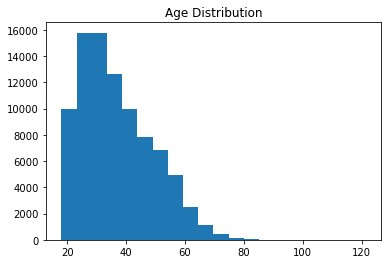

In [48]:
plt.hist(df_str['age'], bins=20)
plt.title('Age Distribution')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

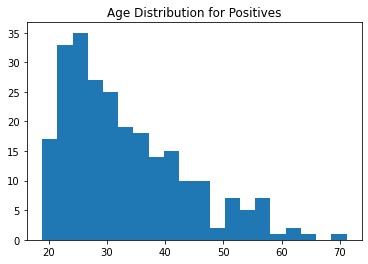

In [49]:
plt.hist(data[data['event']==1]['age'], bins=20)
plt.title('Age Distribution for Positives')
plt.show

In [50]:
def age_group(x):
    if x < 25:
        group = 'lt_25'
    elif x < 35:
        group = '25-35'
    elif x < 45:
        group = '35-45'
    elif x < 55:
        group = '45-55'
    else:
        group = 'gt_55'
    
    return(group)

In [51]:
data['age_cat'] = [age_group(x) for x in data['age']] # group age
data['AB109'] = [1 if x else 0 for x in data['AB109']] # convert true/false values to 1/0

In [53]:
# No augmentation
epochs = 20
batch_size = 32
max_length = 162 
dropout_rate = 0.3
embedding_dim = 200
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

time_1 = time.time()

X = data['soap_obj']
X_2 = data['soap_sub']
X_3 = data['asses_plan']
X_4 = data['quick_notes']
X_5 = pd.get_dummies(data[['Sex','Race','MaritalStatus','age_cat','AB109']])
y = data['event']

j = 0 # to keep track of the iteration number
time_start = time.time()

#pct = 0.5 # Percent of positive cases after undersampling

with open('other/soap_self_harm.csv','a') as fd:
#     fd.write(f'No augmentation_4 heads_maxlen_160_replace_words_5-inputs_Structured_Alex_undersample_{pct}\n')  
    fd.write(f'No augmentation_4 heads_maxlen_160_replace_words_5-inputs_Structured_Alex_NO_undersampling\n')
    
# Run the model 10 times with a different split each time  
for ii in range(6,10):
    time_s = time.time()
    
    j += 1
    iteration = "iter" + str(j)
    
    # Train and test data
    train_index = pd_train_idx_10.iloc[:, ii].values
    test_index = pd_test_idx_10.iloc[:, ii].values
        
    ##################################################################################    
#     # Undersample the negative cases of the training set, no changes to test sets
#     y_train_neg = y[train_index][y[train_index]==0]
#     y_train_pos = y[train_index][y[train_index]==1]

#     num_samples = round((1-pct)/pct*len(y_train_pos)) # Number of samples needed from the negatives
#     samples = y_train_neg.sample(n=num_samples, replace=False, random_state=0) # Downsample training set
    
#     y_train_neg = y_train_neg[samples.index]
#     train_idx_under = pd.concat([y_train_neg, y_train_pos], axis=0).index # Indices for undersmpled training set
            
#     x_train_1, x_test_1 = X[train_idx_under], X[test_index]
#     x_train_2, x_test_2 = X_2[train_idx_under], X_2[test_index]
#     x_train_3, x_test_3 = X_3[train_idx_under], X_3[test_index]
#     x_train_4, x_test_4 = X_4[train_idx_under], X_4[test_index]
#     x_train_5, x_test_5 = X_5.iloc[train_idx_under,:], X_5.iloc[test_index,:]
#     y_train, y_test = y[train_idx_under], y[test_index]
    ##################################################################################
    # The following is for no undersampling
    x_train_1, x_test_1 = X[train_index], X[test_index]
    x_train_2, x_test_2 = X_2[train_index], X_2[test_index]
    x_train_3, x_test_3 = X_3[train_index], X_3[test_index]
    x_train_4, x_test_4 = X_4[train_index], X_4[test_index]
    x_train_5, x_test_5 = X_5.iloc[train_index,:], X_5.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    ##################################################################################

    # Run CNN model
    model_time_start = time.time()


    # Tokenize the text   
    tokenizer = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer.fit_on_texts(x_train_1)
    x_train_1 = tokenizer.texts_to_sequences(x_train_1)
    x_test_1 = tokenizer.texts_to_sequences(x_test_1)
    vocab_size = len(tokenizer.word_index) + 1 # plus the reserved index 0
    word_index = tokenizer.word_index
    
    tokenizer_2 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_2.fit_on_texts(x_train_2)
    x_train_2 = tokenizer_2.texts_to_sequences(x_train_2)
    x_test_2 = tokenizer_2.texts_to_sequences(x_test_2)
    
    tokenizer_3 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_3.fit_on_texts(x_train_3)
    x_train_3 = tokenizer_3.texts_to_sequences(x_train_3)
    x_test_3 = tokenizer_3.texts_to_sequences(x_test_3)
     
    tokenizer_4 = Tokenizer(num_words=5000) # get the frequency of all tokens and use the 5000 most common ones
    tokenizer_4.fit_on_texts(x_train_4)
    x_train_4 = tokenizer_4.texts_to_sequences(x_train_4)
    x_test_4 = tokenizer_4.texts_to_sequences(x_test_4)

    # Pad the sequences with 0's
    x_train_1 = pad_sequences(x_train_1, padding='post', maxlen=max_length) 
    x_test_1 = pad_sequences(x_test_1, padding='post', maxlen=max_length)
    
    x_train_2 = pad_sequences(x_train_2, padding='post', maxlen=max_length) 
    x_test_2 = pad_sequences(x_test_2, padding='post', maxlen=max_length)
    
    x_train_3 = pad_sequences(x_train_3, padding='post', maxlen=max_length) 
    x_test_3 = pad_sequences(x_test_3, padding='post', maxlen=max_length)
    
    x_train_4 = pad_sequences(x_train_4, padding='post', maxlen=max_length) 
    x_test_4 = pad_sequences(x_test_4, padding='post', maxlen=max_length)

    # Fit the Transformer model
    mymodel = transformer_model_5_structured(vocab_size, embedding_dim,max_length,dropout_rate)
    mymodel.fit([x_train_1,x_train_2,x_train_3,x_train_4,x_train_5], y_train, epochs=epochs, batch_size=batch_size)

    # Collect and log evaluation metrics
    auc_roc, auc_pr, acc, precision, recall, specificity,f1,tn,fp,fn,tp = evaluate(mymodel, [x_test_1,x_test_2,x_test_3,x_test_4,x_test_5], y_test)
    model_time = time.time() - model_time_start

    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'{iteration},{auc_roc},{auc_pr},{acc},{precision},{recall},{specificity},{f1},{tn}, {fp}, {fn}, {tp}\n')

    del mymodel, tokenizer, tokenizer_2, tokenizer_3, tokenizer_4 
    gc.collect()
    
    time_e = time.time() - time_s
    with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'1 iteration 18 DA,{time_e}\n')

running_time = time.time() - time_start
with open('other/soap_self_harm.csv','a') as fd:
        fd.write(f'10 iteration training time,{running_time}\n')

Epoch 1/20
1925/1925 [==============================] - 3137s 2s/step - loss: 0.0205 - auc: 0.6406
Epoch 2/20
1925/1925 [==============================] - 3003s 2s/step - loss: 0.0158 - auc: 0.7642
Epoch 3/20
1925/1925 [==============================] - 2960s 2s/step - loss: 0.0111 - auc: 0.8556
Epoch 4/20
1925/1925 [==============================] - 2975s 2s/step - loss: 0.0071 - auc: 0.9237
Epoch 5/20
1925/1925 [==============================] - 2964s 2s/step - loss: 0.0050 - auc: 0.9552
Epoch 6/20
1925/1925 [==============================] - 2957s 2s/step - loss: 0.0033 - auc: 0.9793
Epoch 7/20
1925/1925 [==============================] - 2961s 2s/step - loss: 0.0022 - auc: 0.9853
Epoch 8/20
1925/1925 [==============================] - 2953s 2s/step - loss: 0.0014 - auc: 0.9913
Epoch 9/20
1925/1925 [==============================] - 2968s 2s/step - loss: 0.0015 - auc: 0.9884
Epoch 10/20
1925/1925 [==============================] - 2963s 2s/step - loss: 0.0018 - auc: 0.9883
Epoch 11/